Setup Google Colab and Dataset

In [0]:
# Mount google drive to colab
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
# Download the training dataset
!wget --header="Host: doc-08-3o-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://drive.google.com/drive/folders/1pEBmIl1tbuwYrsfeUv2KDz8a2gR0Fjxe" --header="Cookie: AUTH_nnb6jka5tpm79utnnl32qa140lcrgttl_nonce=pm00v4qjkjqnc" --header="Connection: keep-alive" "https://doc-08-3o-docs.googleusercontent.com/docs/securesc/7kg9pm26jg8sdtodrd2jal778lctr8oe/tdr1p4kvodr6to9dchp4qbvcf6j7mks1/1591018200000/06629147635963609455/02518230046088755184/1l1adJnTgeHULVuoLdTRyqi25-z6shBSL?e=download&authuser=0&nonce=pm00v4qjkjqnc&user=02518230046088755184&hash=n3pmg5il46prtr9fn2lfrn8eauduf4gl" -c -O 'train.csv'

In [0]:
# Copy the file to the project directory on google drive
!cp train.csv /content/drive/My\ Drive/Colab\ Notebooks/FacebookChallenge/

In [0]:
# Change the current working directory of Google Colab
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/FacebookChallenge/")

In [0]:
# Remove the header
with open("train.csv",'r') as f:
    with open("data.csv",'w') as f1:
        next(f)
        for line in f:
            f1.write(line)

In [1]:
# Imports
import networkx as nx
import os
from warnings import filterwarnings
import random
from random import randint
from pickle import dump,load
import numpy as np
import pandas as pd
from tqdm import tqdm
from math import sqrt
from scipy.sparse.linalg import svds
from numpy import memmap
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from hyperopt import STATUS_OK,hp,tpe,Trials,fmin
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Global Params
os.chdir("/content/drive/My Drive/Colab Notebooks/FacebookChallenge/")
filterwarnings("ignore")
random.seed(10)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load the pre-computer features

In [0]:
# Function to store numpy array to the disk
def writeVar(myVar,var_name,dat_type):
  mem_map = np.memmap(var_name, mode='w+', shape=myVar.shape,dtype=dat_type)
  mem_map[:] = myVar[:]
  mem_map.flush()

In [0]:
graph = load(open('graph.p','rb'))

In [0]:
num_edges = len(np.genfromtxt('data.csv',delimiter=','))
num_nodes = len(set(np.genfromtxt('data.csv',delimiter=',').ravel()))

In [0]:
# Load the data i.e. source,destination nodes
data = np.memmap("edge_data.dat", mode='r', shape=(2*num_edges,2),dtype='uint32')

# Load their labels i.e. whether 1 or 0
labels = np.memmap("edge_label.dat", mode='r', shape=(data.shape[0],1),dtype='uint8')

In [0]:
# Load the precomputed dataset
# SKIP NEXT CELL IF PRECOMPUTED ALREADY

# Load the precomputed Jaccard distances

# Load jaccard distance for followers
jaccard_1 = np.memmap("jacc1.dat", mode='r', shape=labels.shape,dtype='float32')

# Load jaccard distance for followees
jaccard_2 = np.memmap("jacc2.dat", mode='r', shape=labels.shape,dtype='float32')

# Load the cosine similarity for followers
cosine1 = np.memmap("cos1.dat", mode='r', shape=labels.shape,dtype='float32')

# Load the cosine similarity for followees
cosine2 = np.memmap("cos2.dat", mode='r', shape=labels.shape,dtype='float32')

# Load the page rank features
page_rank_features = np.memmap("page_ran.dat", mode='r', shape=data.shape,dtype='float32')

# Load the shortest paths
shortest_path = np.memmap("shortest_path.dat", mode='r', shape=labels.shape,dtype='int32')

# Load feature: whether belongs to same community
community = np.memmap("community.dat", mode='r', shape=labels.shape,dtype='uint8')

# Load the adamic features
adar = np.memmap("adar.dat", mode='r+', shape=labels.shape,dtype='float32')

# Load follows back
follows_back = np.memmap("follows_back.dat", mode='r', shape=labels.shape,dtype='uint8')

# Load the kartz features
kartz_features = np.memmap("kartz.dat", mode='r', shape=data.shape,dtype='float32')

# Load the hub scores
hubs_scores = np.memmap("hubs.dat", mode='r', shape=data.shape,dtype='float32')

# Load the authority scores
authority_scores = np.memmap("authority.dat", mode='r', shape=data.shape,dtype='float32')

# load source & destination followers
followers = np.memmap("followers.dat", mode='r', shape=data.shape,dtype='uint32')

# load source & destination followees
followees = np.memmap("followees.dat", mode='r', shape=data.shape,dtype='uint32')

# Load the SVD Features
svd_features = np.memmap("svd_features.dat", mode='r', shape=(data.shape[0],24),dtype='float32')

# Load the preferential attachment feature
preferential = np.memmap("pref.dat", mode='r', shape=(labels.shape),dtype='uint32')

# Load the preferential attachment feature
svd_dot = np.memmap("svd_dot.dat", mode='r', shape=(data.shape),dtype='float32')

In [0]:
# My list of features
FEATURES = ['jaccard_followers','jaccard_followees','cosine_followers','cosine_followees','page_rank_source',
            'page_rank_dest','shortest_path','belongs_to_same_community','adamic','does_follow_back','kartz_source',
            'kartz_dest','hubs_source','hubs_dest','authority_source','authority_dest','followers_source','followers_dest',
            'followees_source','followees_dest','svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
            'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
            'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
            'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
            'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
            'svd_dot_u','svd_dot_v','preferential']

In [0]:
combined_features = np.memmap("combined_features.dat", mode='r', shape=(18875038, 47),dtype='float32')

Converting the problem to a classification problem

In [0]:
# Load the graph
graph = nx.read_edgelist('data.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(graph))
dump(graph,open('graph.p','wb'))

In [0]:
# Preparing the dataset

true_edges = np.genfromtxt("data.csv",delimiter=",",dtype=int)
false_edges = np.zeros((num_edges,2),dtype=int)

true_edges_dict = dict()
false_edges_set = set()

# Create a dictionary of existing edges in the graph
for edge in true_edges:
  true_edges_dict[(edge[0],edge[1])] = 1

# Now add the missing edges
while(len(false_edges_set) < num_edges):
  a,b = randint(1,num_nodes),randint(1,num_nodes)
  isEdge = true_edges_dict.get((a,b),-1)

  if isEdge==-1 and a!=b :
    false_edges_set.add((a,b))
  else:
    continue

for i,edge in enumerate(false_edges_set):
  false_edges[i][0],false_edges[i][1] = edge[0],edge[1]

data = np.vstack((true_edges,false_edges))
labels = np.vstack( ( np.ones((num_edges,1)) , np.zeros((num_edges,1)) ) )

writeVar(data,"edge_data.dat",'uint32')
writeVar(labels,"edge_label.dat",'uint8')


Jaccard Distances

In [0]:
def jaccard_of_followers(a,b):
  succ_a = set(graph.successors(a))
  succ_b = set(graph.successors(b))

  if len(succ_a)==0 or len(succ_b)==0:
    return 0
  else:
    dist = len(succ_a.intersection(succ_b))/len(succ_a.union(succ_b))
    return dist

In [0]:
def jaccard_of_followees(a,b):
  succ_a = set(graph.predecessors(a))
  succ_b = set(graph.predecessors(b))

  if len(succ_a)==0 or len(succ_b)==0:
    return 0
  else:
    dist = len(succ_a.intersection(succ_b))/len(succ_a.union(succ_b))
    return dist

In [0]:
jaccard_1 = np.zeros(labels.shape)
jaccard_2 = np.zeros(labels.shape)

for i,edge in tqdm(enumerate(data)):
  a,b = edge[0],edge[1]
  jaccard_1[i],jaccard_2[i] = jaccard_of_followers(a,b),jaccard_of_followees(a,b)


writeVar(jaccard_1,"jacc1.dat",'float32')
writeVar(jaccard_2,"jacc2.dat",'float32')

18875038it [11:44, 26791.81it/s]


Cosine Similarity

In [0]:
def cosine_followers(a,b):
  succ_a = set(graph.successors(a))
  succ_b = set(graph.successors(b))

  if len(succ_a)==0 or len(succ_b)==0:
    return 0
  else:
    sim = len(succ_a.intersection(succ_b)) / ( sqrt(len(succ_a) * len(succ_b)) )
    return sim

In [0]:
def cosine_followees(a,b):
  succ_a = set(graph.predecessors(a))
  succ_b = set(graph.predecessors(b))

  if len(succ_a)==0 or len(succ_b)==0:
    return 0
  else:
    sim = len(succ_a.intersection(succ_b)) / ( sqrt(len(succ_a) * len(succ_b)) )
    return sim

In [0]:
cosine1 = np.zeros(labels.shape)
cosine2 = np.zeros(labels.shape)

for i,edge in tqdm(enumerate(data)):
  a,b = edge[0],edge[1]
  cosine1[i],cosine2[i] = cosine_followers(a,b),cosine_followees(a,b)

writeVar(cosine1,"cos1.dat",'float32')
writeVar(cosine2,"cos2.dat",'float32')

18875038it [10:59, 28601.16it/s]


Page Ranking

In [0]:
page_rank_dict = nx.pagerank(graph, alpha=0.85)

In [0]:
page_rank_features = np.zeros(data.shape)
for i,edge in enumerate(data):
  source_rank = page_rank_dict.get(edge[0])
  dest_rank = page_rank_dict.get(edge[1])
  page_rank_features[i][0] = source_rank
  page_rank_features[i][1] = dest_rank
writeVar(page_rank_features,"page_ran.dat",'float32')

Shortest Path

In [0]:
shortest_path = np.zeros(labels.shape,dtype='int32')

In [0]:
def get_shortest_path(a,b):
  try:
    if graph.has_edge(a,b):
      graph.remove_edge(a,b)
      dist = nx.shortest_path_length(graph,source=a,target=b)
      graph.add_edge(a,b)
      return(-1*dist)
    else:
      dist = nx.shortest_path_length(graph,source=a,target=b)
      return(-1*dist)
  except:
    return -1

In [0]:
for i,edge in tqdm(enumerate(data)):
  shortest_path[i] = get_shortest_path(edge[0],edge[1])


18875038it [2:41:32, 1947.42it/s]


In [0]:
writeVar(shortest_path,"shortest_path.dat",'int32')

Do the two nodes belong to same community ?

In [0]:
community = np.zeros(labels.shape,dtype='uint8')

In [0]:
wcc = list(nx.weakly_connected_components(graph))

In [0]:
def belongs_to_same_wcc(a,b):
  index = []
  if graph.has_edge(b,a):
      return 1
  if graph.has_edge(a,b):
          for i in wcc:
              if a in i:
                  index= i
                  break
          if (b in index):
              graph.remove_edge(a,b)
              if get_shortest_path(a,b)==-1:
                  graph.add_edge(a,b)
                  return 0
              else:
                  graph.add_edge(a,b)
                  return 1
          else:
              return 0
  else:
          for i in wcc:
              if a in i:
                  index= i
                  break
          if(b in index):
              return 1
          else:
              return 0

In [0]:
for i,edge in tqdm(enumerate(data)):
  a = edge[0]
  b = edge[1]
  community[i] = belongs_to_same_wcc(a,b)
writeVar(community,"community.dat",'uint8')

18875038it [27:03, 11627.66it/s]


Adar Index

In [0]:
def get_adar(a,b):
  adar = 0
  common = set(graph.successors(a)).intersection(set(graph.successors(b)))
  if len(common) != 0:
    for u in common:
      adar += 1/(np.log10(len(list(graph.predecessors(u)))))
  return adar

In [0]:
adar = np.zeros(labels.shape)

In [0]:
for i,edge in tqdm(enumerate(data)):
  adar[i] = get_adar(edge[0],edge[1])
writeVar(adar,"adar.dat",'float32')

18875038it [13:52, 22685.31it/s]


Does the person follow back

In [0]:
def does_follow_back(a,b):
  if graph.has_edge(b,a):
    return 1
  else:
    return 0

In [0]:
follows_back = np.zeros(labels.shape)
for i,edge in tqdm(enumerate(data)):
  follows_back[i] = does_follow_back(edge[0],edge[1])
writeVar(follows_back,"follows_back.dat",'uint8')

18875038it [04:22, 71843.65it/s]


Kartz Centrality

In [0]:
kartz_dict = nx.katz.katz_centrality(graph,alpha=0.005,beta=1)

In [0]:
kartz_features = np.zeros(data.shape)
for i,edge in tqdm(enumerate(data)):
  source_kartz = kartz_dict.get(edge[0])
  dest_kartz = kartz_dict.get(edge[1])
  kartz_features[i][0] = source_kartz
  kartz_features[i][1] = dest_kartz
writeVar(kartz_features,"kartz.dat",'float32')

18875038it [05:25, 58015.57it/s]


HITS Score

In [0]:
hubs,authority = nx.hits(graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)

In [0]:
hubs_scores = np.zeros(data.shape)
for i,edge in tqdm(enumerate(data)):
  source_hubs = hubs.get(edge[0])
  dest_hubs = hubs.get(edge[1])
  hubs_scores[i][0] = source_hubs
  hubs_scores[i][1] = dest_hubs
writeVar(hubs_scores,"hubs.dat",'float32')

18875038it [05:33, 56591.08it/s]


In [0]:
authority_scores = np.zeros(data.shape)
for i,edge in tqdm(enumerate(data)):
  source_authority = authority.get(edge[0])
  dest_authority = authority.get(edge[1])
  authority_scores[i][0] = source_authority
  authority_scores[i][1] = dest_authority
writeVar(authority_scores,"authority.dat",'float32')

18875038it [05:30, 57030.24it/s]


Followers of Source and destination

In [0]:
followers = np.zeros(data.shape)

In [0]:
for i,edge in tqdm(enumerate(data)):
  followers[i][0] = len(list(graph.predecessors(edge[0])))
  followers[i][1] = len(list(graph.predecessors(edge[1])))

18875038it [07:14, 43477.78it/s]


Followees of Source and Destination

In [0]:
followees = np.zeros(data.shape)

In [0]:
for i,edge in tqdm(enumerate(data)):
  followees[i][0] = len(list(graph.successors(edge[0])))
  followees[i][1] = len(list(graph.successors(edge[1])))

18875038it [07:01, 44812.33it/s]


In [0]:
writeVar(followers,"followers.dat",'uint32')
writeVar(followees,"followees.dat",'uint32')

SVD Features

In [0]:
# Matrix to hold the SVD Features
svd_feature_matrix = np.zeros((data.shape[0],24))

In [0]:
svd_feature_matrix.shape

(18875038, 24)

In [0]:
# Adjacency matrix
Adj = nx.adjacency_matrix(graph,nodelist=sorted(graph.nodes())).asfptype()

In [0]:
# Perform SVD Decomposition of Adjacency matrix
U, s, V = svds(Adj, k = 6)

In [0]:
V_T = V.T

In [0]:
for i,edge in tqdm(enumerate(data)):
  source = edge[0]
  dest = edge[1]
  feature1 = U[source-1]
  feature2 = V_T[source-1]
  feature3 = U[dest-1]
  feature4 = V_T[dest-1]
  svd_feature_matrix[i][0:6] = feature1
  svd_feature_matrix[i][6:12] = feature2
  svd_feature_matrix[i][12:18] = feature3
  svd_feature_matrix[i][18:24] = feature4


18875038it [06:18, 49825.92it/s]


In [0]:
writeVar(svd_feature_matrix,"svd_features.dat",'float32')

SVD Dot Feature

In [0]:
svd_dot_feature = np.zeros(data.shape)

In [0]:
for i,edge in tqdm(enumerate(data)):
  source = edge[0]
  dest = edge[1]
  feature1 = U[source-1]
  feature2 = V_T[source-1]
  feature3 = U[dest-1]
  feature4 = V_T[dest-1]
  svd_dot_feature[i][0] = np.dot(feature1,feature3)
  svd_dot_feature[i][1] = np.dot(feature2,feature4)

18875038it [06:42, 46941.47it/s]


In [0]:
writeVar(svd_dot_feature,"svd_dot.dat",'float32')

In [0]:
# Combine all the features
combined_features = np.hstack((jaccard_1,jaccard_2,cosine1,cosine2,page_rank_features,
                               shortest_path,community,adar,follows_back,kartz_features,hubs_scores,
                               authority_scores,followers,followees,svd_features,preferential,svd_dot))

Preferential Attachment Feature<br>
The preferential attachment of two vertices is calculated as the multiplication of the number of followers(i.e. successors) of each vertex

In [0]:
def pref_attachment(a,b):
  succ_a = len(list(graph.predecessors(a)))
  succ_b = len(list(graph.predecessors(b)))
  return succ_a*succ_b

In [0]:
preferential = np.zeros(labels.shape)

In [0]:
for i,edge in tqdm(enumerate(data)):
  preferential[i] = pref_attachment(edge[0],edge[1])

18875038it [06:36, 47548.85it/s]


In [0]:
writeVar(preferential,"pref.dat",'uint32')

## Exploratory Data Analysis

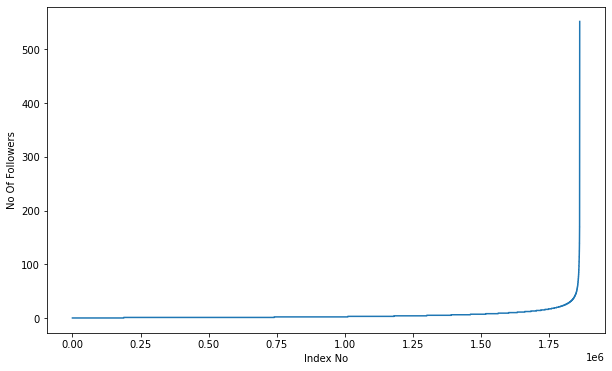

In [3]:
indegree_dist = list(dict(graph.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

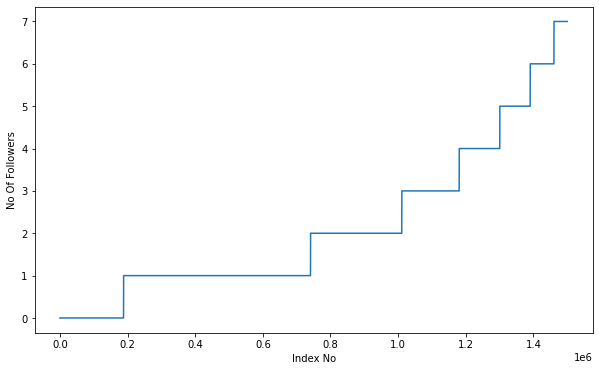

In [8]:
indegree_dist = list(dict(graph.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

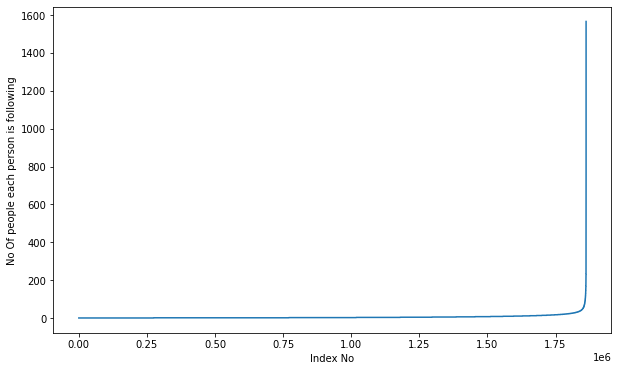

In [5]:
outdegree_dist = list(dict(graph.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

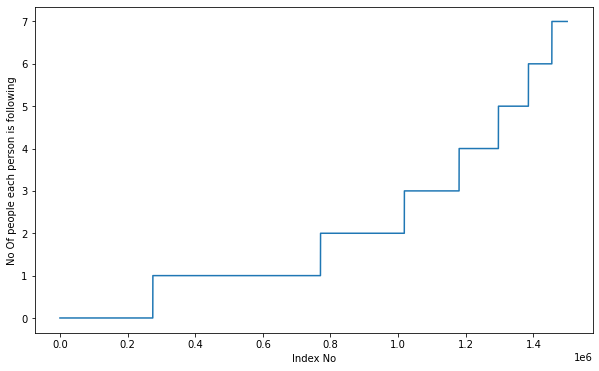

In [9]:
indegree_dist = list(dict(graph.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

<br>

<h2>
Split the data as:<br>
Training: 80%<br>
Test: 10%<br>
Cross Validation: 10%
</h2>

In [0]:
X_train, X_temp, y_train, y_temp = train_test_split(combined_features, labels, test_size=0.2, random_state=10,stratify=labels)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=20,stratify=y_temp)

<br>

## Performing Hyperparameter Tuning of XGBoost using Bayesian Optimization 
We want hyper-parameters that will maximize the F1-Score

Get the Values of the Best Hyper Parameters giving highest F1 Score

The Objective is to get the hyper-parameters that will maximize the F1 Score.<br>
In other words this is similar to minimizing (-1 * F1-Score)

In [0]:
def objective(hyperparameters):
  MAX_DEPTH = int(hyperparameters.get("max_depth"))
  MIN_CHILD_WT = hyperparameters.get("min_child_weight")
  LEARNING_RATE = hyperparameters.get("learning_rate")
  SUBSAMPLE = hyperparameters.get("subsample")
  GAMMA = hyperparameters.get("gamma")
  COLSAM = hyperparameters.get("colsample_bytree")
  REGALPHA = hyperparameters.get("reg_alpha")
  N_ESTIM = hyperparameters.get("n_estimators")

  model = XGBClassifier(learning_rate=LEARNING_RATE,max_depth=MAX_DEPTH,
                        min_child_weight=MIN_CHILD_WT,subsample=SUBSAMPLE,gamma=GAMMA,
                        colsample_bytree=COLSAM,reg_alpha=REGALPHA,n_estimators=N_ESTIM,tree_method='gpu_hist')
  model.fit(X_train, y_train)
  y_pred = model.predict(X_cv)
  predictions = [round(value) for value in y_pred]
  f1 = f1_score(y_cv, predictions)
  f1 = f1 * 100.0 * -1
  return {'loss':f1, 'params':hyperparameters, 'status':STATUS_OK}

space = {
  'max_depth': hp.quniform('max_depth', 2, 10, 1),
  'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
  'learning_rate': hp.uniform('learning_rate', 0.1, 1.0),
  'subsample': hp.uniform('subsample', 0.0, 1.0),
  'gamma': hp.uniform ('gamma', 1,9),
  'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
  'reg_alpha' : hp.quniform('reg_alpha', 1,180,1),
  'n_estimators' : hp.choice('n_estimators', np.arange(1, 301, dtype=int))
}

MAX_EVALS = 10
tpe_algorithm = tpe.suggest
bayes_trials = Trials()
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 10/10 [06:31<00:00, 39.15s/it, best loss: -99.10595678950175]


In [0]:
MAX_DEPTH = int(best.get("max_depth"))
MIN_CHILD_WT = int(best.get("min_child_weight"))
LEARNING_RATE = float(best.get("learning_rate"))
SUBSAMPLE = float(best.get("subsample"))
GAMMA = float(best.get("gamma"))
COLSAM = float(best.get("colsample_bytree"))
REGALPHA = int(best.get("reg_alpha"))
N_ESTIM = int(best.get("n_estimators"))

In [9]:
# Best hyper-param values obtained from bayesian optimization
print("Best hyper params are:\nMax Depth: {}\nMin Child Weight: {}\nLearning Rate: {}\n\
Subsample: {}\nGamma: {}\nColumnsample bytree: {}\nReg Alpha: {}\nNumber of Estimators: {}".format( \
    MAX_DEPTH,MIN_CHILD_WT,LEARNING_RATE,SUBSAMPLE,GAMMA,COLSAM,REGALPHA,N_ESTIM \
))

Best hyper params are:
Max Depth: 8
Min Child Weight: 2
Learning Rate: 0.7863882061175492
Subsample: 0.30818390159730535
Gamma: 1.165671352514594
Columnsample bytree: 0.2553377093803131
Reg Alpha: 55
Number of Estimators: 263


Training an XGBoost Classifier with the optimal Hyperparameters

In [0]:
model = XGBClassifier(learning_rate=LEARNING_RATE,max_depth=MAX_DEPTH,
                        min_child_weight=MIN_CHILD_WT,subsample=SUBSAMPLE,gamma=GAMMA,
                        colsample_bytree=COLSAM,reg_alpha=REGALPHA,n_estimators=N_ESTIM,tree_method='gpu_hist')

In [0]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7026926395464955,
              gamma=4.724164390158622, learning_rate=0.8914769400792811,
              max_delta_step=0, max_depth=10, min_child_weight=7, missing=None,
              n_estimators=167, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=74,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.569836698505629, tree_method='gpu_hist', verbosity=1)

In [0]:
# Storing the best model
dump(model,open('best_model.p','wb'))

In [0]:
best_model = load(open('best_model.p','rb'))

In [0]:
important_features = best_model.feature_importances_
indices = (np.argsort(feat))[-10:]

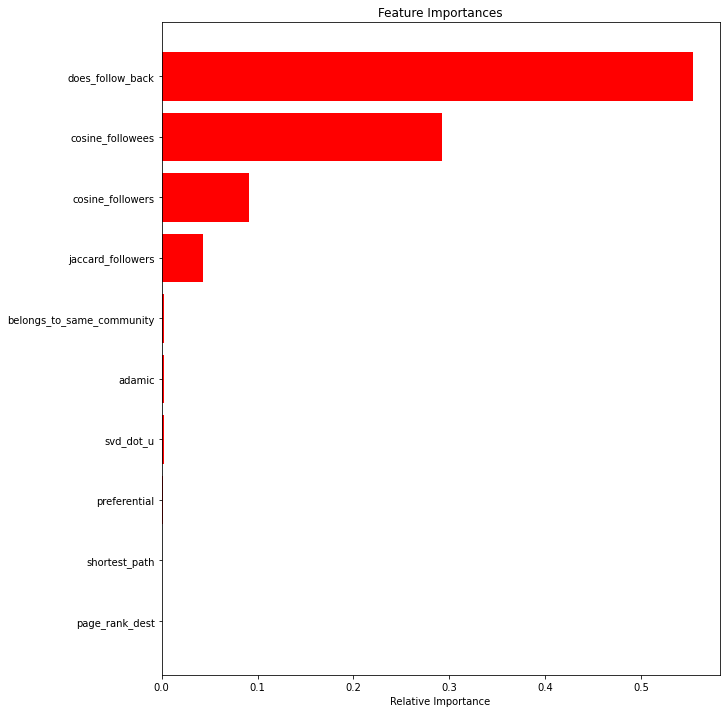

In [40]:
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), important_features[indices], color='r', align='center')
plt.yticks(range(len(indices)), [FEATURES[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [0]:
def plot_confusion_matrix(test_y, predict_y):
  C = confusion_matrix(test_y, predict_y)
    
  A =(((C.T)/(C.sum(axis=1))).T)
    
  B =(C/C.sum(axis=0))
  plt.figure(figsize=(20,4))
    
  labels = [0,1]
  # representing A in heatmap format
  cmap=sns.light_palette("blue")
  plt.subplot(1, 3, 1)
  sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Confusion matrix")
    
  plt.subplot(1, 3, 2)
  sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Precision matrix")
    
  plt.subplot(1, 3, 3)
  # representing B in heatmap format
  sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Recall matrix")
    
  plt.show()

In [0]:
print("Training accuracy is: \n{}".format(accuracy_score(y_train,y_train_pred)))

Training accuracy is: 
0.9922265717352879


In [0]:
print("Training F1-Score is: \n{}".format(f1_score(y_train,y_train_pred)))

Training F1-Score is: 
0.9922228732295673


Train confusion_matrix


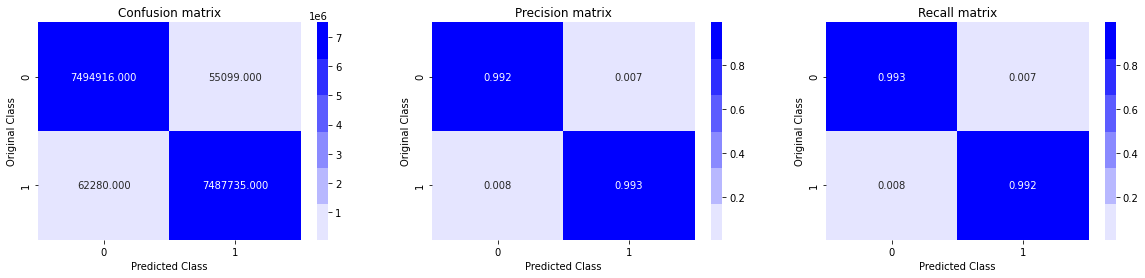

In [0]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)

<br>

In [0]:
print("Testing accuracy is: \n{}".format(accuracy_score(y_test,y_test_pred)))

Testing accuracy is: 
0.9912111444532038


In [0]:
print("Testing F1-Score is: \n{}".format(f1_score(y_test,y_test_pred)))

Testing F1-Score is: 
0.9912064809862481


Test confusion_matrix


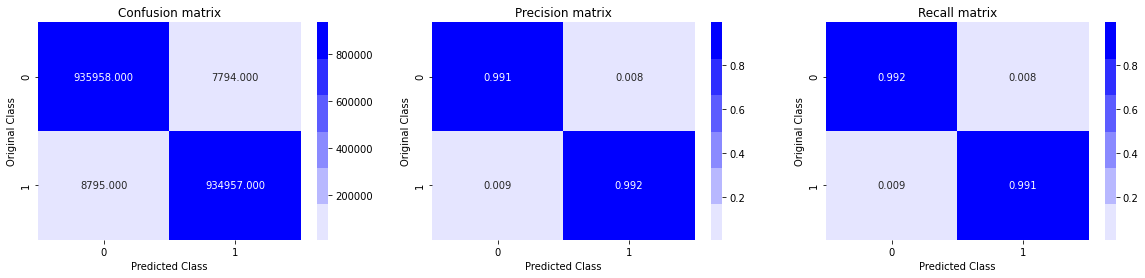

In [0]:
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)